# Intialize

Thanks to Yuuki Omori for feedback on this notebook!

In [44]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time


# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66,
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
 
}




common_params = {

'z_min' : 0.005,
'z_max' : 3.0,
'ndim_redshifts': 100,
    
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
'ndim_masses': 100,
    
  

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'non_linear' : 'hmcode',

'hm_consistency' : 1,
}

T_cmb = 2.7255 

In [45]:
import classy_sz
classy_sz.__file__


'/Users/boris/opt/miniconda3/lib/python3.9/site-packages/classy_sz-2.9.4-py3.9-macosx-11.0-arm64.egg/classy_sz.cpython-39-darwin.so'

In [46]:
ksz_params = {
'output': 'kSZ_kSZ_1h,kSZ_kSZ_2h',

# 'pressure profile':'B16',
# 'gas profile mode' :'agn',
    
"ell_min" : 2,
"ell_max" : 8000,
'dell': 0,
'dlogell': 0.2,
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters
'use_xout_in_density_profile_from_enclosed_mass' : 1,


    

'n_m_density_profile' :100, # default: 100, decrease for faster
'n_z_density_profile' :100, # default: 100, decrease for faster


'N_samp_fftw' : 1024,
    
    
'hm_consistency' : 1, ## VERY IMPORTANT : Account for low-mass contribution, see appendix B2 of https://arxiv.org/pdf/2208.07847.pdf
    
    
'use_fft_for_profiles_transform' : 1,
    
    
'x_min_gas_density_fftw' : 1e-8,
'x_max_gas_density_fftw' : 1e8,    
    
}

## FFTLog vs GSL for Battaglia model 

In [47]:
%%time

M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set(ksz_params)

M.set({
'use_fft_for_profiles_transform' : 1,
})
M.compute() # fast mode doesnt work yet because of velocity

CPU times: user 38.5 s, sys: 195 ms, total: 38.7 s
Wall time: 7.62 s


In [48]:
%%time
Mgsl = Class()

Mgsl.set(common_params)
Mgsl.set(cosmo_params)
Mgsl.set(ksz_params)

Mgsl.set({
'use_fft_for_profiles_transform' : 0,
'n_k_density_profile' :100, # default 80
'nfw_profile_epsrel':1e-4,
    
'k_min_gas_density_profile' : 1e-4,
'k_max_gas_density_profile' : 1e3, 
    
'k_min_for_pk_class_sz' : 1e-4,
})
Mgsl.compute() # fast mode doesnt work yet because of velocity

CPU times: user 6min, sys: 17.1 s, total: 6min 17s
Wall time: 1min 5s


In [52]:
l_b16_fft = np.asarray(M.cl_sz()['ell'])
cl_ksz_1h_b16_fft = np.asarray(M.cl_ksz()['1h']) ## in fact this is Dl.
cl_ksz_2h_b16_fft = np.asarray(M.cl_ksz()['2h']) ## in fact this is Dl.

l_gsl = np.asarray(Mgsl.cl_sz()['ell'])
cl_ksz_1h_gsl = np.asarray(Mgsl.cl_ksz()['1h']) ## in fact this is Dl.
cl_ksz_2h_gsl = np.asarray(Mgsl.cl_ksz()['2h']) ## in fact this is Dl.

[]

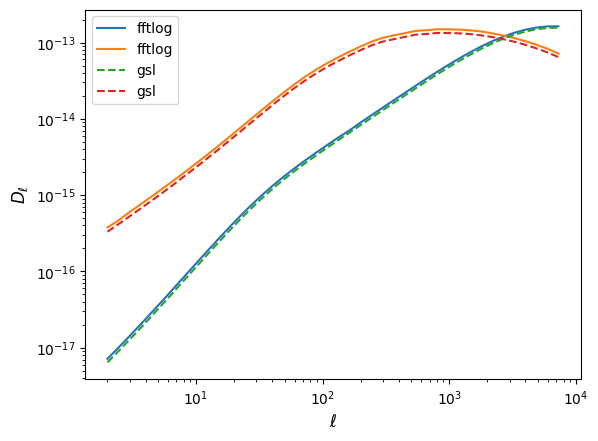

In [53]:
plt.plot(l_b16_fft,cl_ksz_1h_b16_fft,label='fftlog')
plt.plot(l_b16_fft,cl_ksz_2h_b16_fft,label='fftlog')
plt.plot(l_gsl,cl_ksz_1h_gsl,ls='--',label='gsl')
plt.plot(l_gsl,cl_ksz_2h_gsl,ls='--',label='gsl')
plt.xlabel(r"$\ell$",size=12)
plt.ylabel(r"$D_\ell$",size=12)
plt.legend()
plt.loglog()

The slight mismatch can be fixed by increasing number of points in grids for m,z and profile.
We advise using FFT rather than GSL (it's faster and better).
So switch:
```
'use_fft_for_profiles_transform' : 1
```

## FFTLog vs GSL for NFW model 

In [54]:
%%time

M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set(ksz_params)

M.set({
'gas profile':'nfw',
'use_fft_for_profiles_transform' : 1, # it is in fact bypassed in the nfw case
'n_k_density_profile' :100, # default 80
'nfw_profile_epsrel':1e-4,
    
'k_min_gas_density_profile' : 1e-4,
'k_max_gas_density_profile' : 1e3, 
'x_out_truncated_density_profile (electrons)': 1., 
'use_xout_in_density_profile_from_enclosed_mass': 0,
})
M.compute() # fast mode doesnt work yet because of velocity

CPU times: user 33.7 s, sys: 130 ms, total: 33.9 s
Wall time: 6.2 s


In [55]:
l_nfw = np.asarray(M.cl_sz()['ell'])
cl_ksz_1h_nfw = np.asarray(M.cl_ksz()['1h'])
cl_ksz_2h_nfw = np.asarray(M.cl_ksz()['2h'])


[]

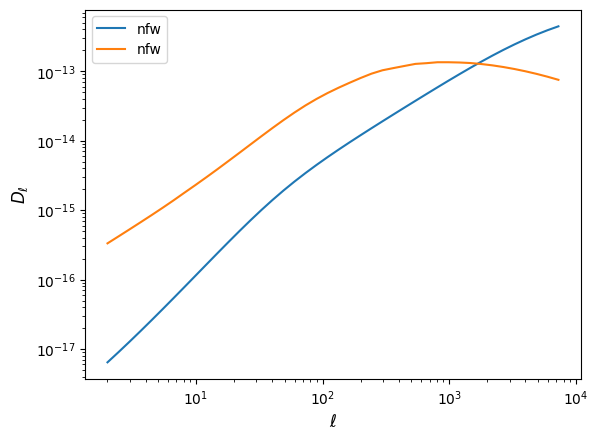

In [56]:
plt.plot(l_nfw,cl_ksz_1h_nfw,label='nfw')
plt.plot(l_nfw,cl_ksz_2h_nfw,label='nfw')
plt.xlabel(r"$\ell$",size=12)
plt.ylabel(r"$D_\ell$",size=12)
plt.legend()
plt.loglog()

## BCM model 

In [57]:
%%time

M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set(ksz_params)

M.set({
'use_fft_for_profiles_transform' : 1,
    
'gas profile':'BCM',
'use_xout_in_density_profile_from_enclosed_mass' : 0,

})
M.compute() # fast mode doesnt work yet because of velocity

CPU times: user 1min 14s, sys: 307 ms, total: 1min 14s
Wall time: 14 s


In [58]:
l_bcm = np.asarray(M.cl_sz()['ell'])
cl_ksz_1h_bcm = np.asarray(M.cl_ksz()['1h'])
cl_ksz_2h_bcm = np.asarray(M.cl_ksz()['2h'])


## Battaglia AGN model 

In [59]:
%%time


M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set(ksz_params)

M.set({
'gas profile':'B16',
'gas profile mode' : 'agn', # important to read values of parameters
'use_fft_for_profiles_transform' : 1,
'use_xout_in_density_profile_from_enclosed_mass': 1,
'delta for electron density':"200c",
# 'pk_nonlinear_for_vrms2' : 1,
})
M.compute() # fast mode doesnt work yet because of velocity

CPU times: user 38.5 s, sys: 120 ms, total: 38.6 s
Wall time: 6.59 s


In [60]:
l_b16agn = np.asarray(M.cl_sz()['ell'])
cl_ksz_1h_b16agn = np.asarray(M.cl_ksz()['1h'])
cl_ksz_2h_b16agn = np.asarray(M.cl_ksz()['2h'])


## Battaglia AGN model switch off hm_consistency

In this case we dont account for low-mass below m_min.
See Appendix B2 of https://arxiv.org/pdf/2208.07847.pdf and reference. 

So, we set: 
```
'hm_consistency' : 0
```

You certainly want that setting when looking at mass dependence.

In [63]:
%%time


M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set(ksz_params)

M.set({
'gas profile':'B16',
'gas profile mode' : 'agn', # important to read values of parameters
'use_fft_for_profiles_transform' : 1,
'use_xout_in_density_profile_from_enclosed_mass': 1,
'delta for electron density':"200c",
'hm_consistency' : 0,
})
M.compute() # fast mode doesnt work yet because of velocity

CPU times: user 38.2 s, sys: 194 ms, total: 38.4 s
Wall time: 7.41 s


In [64]:
l_b16agn_nolowm = np.asarray(M.cl_sz()['ell'])
cl_ksz_1h_b16agn_nolowm = np.asarray(M.cl_ksz()['1h'])
cl_ksz_2h_b16agn_nolowm = np.asarray(M.cl_ksz()['2h'])


# Plot comparison

[]

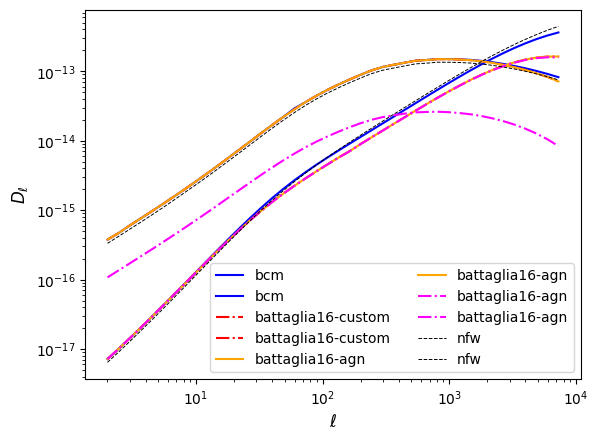

In [71]:
plt.plot(l_bcm,cl_ksz_1h_bcm,label='bcm',c='b')
plt.plot(l_bcm,cl_ksz_2h_bcm,label='bcm',c='b')

plt.plot(l_b16_fft,cl_ksz_1h_b16_fft,label='battaglia16-custom',ls='-.',c='r')
plt.plot(l_b16_fft,cl_ksz_2h_b16_fft,label='battaglia16-custom',ls='-.',c='r')

plt.plot(l_b16agn,cl_ksz_1h_b16agn,label='battaglia16-agn',ls='-',c='orange')
plt.plot(l_b16agn,cl_ksz_2h_b16agn,label='battaglia16-agn',ls='-',c='orange')

plt.plot(l_b16agn_nolowm,cl_ksz_1h_b16agn_nolowm,label='battaglia16-agn',ls='-.',c='magenta')
plt.plot(l_b16agn_nolowm,cl_ksz_2h_b16agn_nolowm,label='battaglia16-agn',ls='-.',c='magenta')

plt.plot(l_nfw,cl_ksz_1h_nfw,label='nfw',lw=0.7,ls='--',c='k')
plt.plot(l_nfw,cl_ksz_2h_nfw,label='nfw',lw=0.7,ls='--',c='k')
plt.xlabel(r"$\ell$",size=12)
plt.ylabel(r"$D_\ell$",size=12)
plt.legend(ncol=2)
plt.loglog()